# Train TPU

## Setup

### System Setup

#### Find out Host System

In [1]:
import socket
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

KAGGLE = True
if socket.gethostname() in ["computerfon-linux", "Computerfon"]:
    KAGGLE = False
print("Running on Kaggle" if KAGGLE else "Running locally")
from tensorflow.python.client import device_lib

for device in device_lib.list_local_devices():
    if device.device_type == "GPU":
        print(device.physical_device_desc)


Running locally
device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:09:00.0, compute capability: 8.6


In [2]:
if KAGGLE:
    !pip install -q efficientnet

#### Imports

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
# conda install -c conda-forge jupyter_contrib_nbextensions
# jupyter contrib nbextsion install --sys-prefix
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

if KAGGLE:
    from kaggle_datasets import KaggleDatasets
import numpy as np
import pandas as pd
from glob import glob
import random
import re

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
%matplotlib inline
sns.set(style="darkgrid")

# Machine Learning
# Pre Processing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#Models
from sklearn.model_selection import train_test_split, KFold
# Deep Learning
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu,False)

import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")


import tensorflow_addons as tfa

#Metrics
from sklearn.metrics import roc_auc_score

# Random Seed Fixing
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

seed_everything()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


#### Select Accelerator

In [5]:
def auto_select_accelerator():
    TPU_DETECTED = False
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print(f"Running on TPU: {tpu.master()}")
        TPU_DETECTED = True
    except ValueError:
        strategy = tf.distribute.get_strategy()
    num_replicas = strategy.num_replicas_in_sync
    print(f"Running on {num_replicas} replica{'s' if (num_replicas > 1) else ''}")
    return strategy, TPU_DETECTED, num_replicas

## Preparation Code

### PARAMS

In [6]:
strategy, TPU_DETECTED, REPLICAS = auto_select_accelerator()
AUTO = tf.data.experimental.AUTOTUNE
KFOLDS = 4
IMG_SIZES = [256] * KFOLDS
BATCH_SIZES = [2] * KFOLDS
EPOCHS = [2] * KFOLDS
EFF_NETS = [1] * KFOLDS

DISPLAY_PLOT = True

Running on 1 replica


In [7]:
train_files = []
for i in range(16):
    if i in [10,11]:
        continue
    if KAGGLE:
        dirpath = KaggleDatasets().get_gcs_path(f"g2nettfrecords{i//2 + 1}")
        tfrecs_fold = tf.io.gfile.glob(f"{dirpath}/train{i:02}-*.tfrec")
    else:
        dirpath = (f"../input/g2net-make-tfrecords-{i//2 + 1}")
        tfrecs_fold = glob(f"{dirpath}/train{i:02}-*.tfrec")
    if len(tfrecs_fold) == 1:
        train_files.append(tfrecs_fold[0])
    #train_files.append(glob(f"{dirpath}/train{i:02}-*.tfrec"))
    
    
train_files

['../input/g2net-make-tfrecords-1\\train00-35000.tfrec',
 '../input/g2net-make-tfrecords-1\\train01-35000.tfrec',
 '../input/g2net-make-tfrecords-2\\train02-35000.tfrec',
 '../input/g2net-make-tfrecords-2\\train03-35000.tfrec',
 '../input/g2net-make-tfrecords-3\\train04-35000.tfrec',
 '../input/g2net-make-tfrecords-3\\train05-35000.tfrec',
 '../input/g2net-make-tfrecords-4\\train06-35000.tfrec',
 '../input/g2net-make-tfrecords-4\\train07-35000.tfrec',
 '../input/g2net-make-tfrecords-5\\train08-35000.tfrec',
 '../input/g2net-make-tfrecords-5\\train09-35000.tfrec',
 '../input/g2net-make-tfrecords-7\\train12-35000.tfrec',
 '../input/g2net-make-tfrecords-7\\train13-35000.tfrec',
 '../input/g2net-make-tfrecords-8\\train14-35000.tfrec',
 '../input/g2net-make-tfrecords-8\\train15-35000.tfrec']

### Reading TFRecords

In [8]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_id": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return prepare_image(example["image"]), tf.reshape(tf.cast(example["target"], tf.float32), [1])

In [9]:
def read_unlabeled_tfrecords(example, return_image_id):
    tfrec_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_id": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return prepare_image(example["image"]), example["image_id"] if return_image_id else 0

In [10]:
def prepare_image(img, dim = IMG_SIZES[0]):
    img = tf.image.resize(tf.image.decode_png(img, channels = 3), size = (dim, dim))
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.reshape(img, [dim, dim, 3])
    
    return img

In [11]:
def count_data_items(file_ids):
    n = [int(re.compile(r"-(\d*)\.").search(file_id).group(1)) for file_id in file_ids]
    return np.sum(n)

In [12]:
count_data_items(train_files)

490000

### Dataset Creation

In [13]:
def get_dataset(files, shuffle = False, repeat = False,
               labeled = True, return_image_ids=True, batch_size=16, dim=IMG_SIZES[0]):
    ds = tf.data.TFRecordDataset(files, num_parallel_reads = AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    if shuffle:
        ds = ds.shuffle(1024 * 2)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    if labeled:
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls = AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecords(example, return_image_ids),
                   num_parallel_calls = AUTO)
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

### Build Model

In [14]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3,
       efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def build_model(size, ef=0, count=820):
    inp = tf.keras.layers.Input(shape = (size, size, 3))
    base = EFNS[ef](input_shape = (size, size, 3), weights = "imagenet", include_top = False)
    
    x = base(inp)
    
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(1)(x)
    x = tf.keras.layers.Activation("sigmoid", dtype="float32")(x)
    model = tf.keras.Model(inputs = inp, outputs = x)
    lr_decayed_fn = tf.keras.experimental.CosineDecay(
        1e-3,
        count
    )
    
    opt = tfa.optimizers.AdamW(lr_decayed_fn, learning_rate = 1e-4)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer = opt, loss = loss, metrics = ["AUC"])
    return model

### Training

In [15]:
def vis_lr_callback(batch_size = 8):
    lr_start = 1e-4
    lr_max = 0.000015 * REPLICAS * batch_size
    lr_min = 1e-5
    lr_ramp_ep = 3
    lr_sus_ep = 0
    lr_decay = 0.7
    
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        
        return lr
    plt.figure(figsize = (10,7))
    plt.plot([lrfn(i) for i in range(EPOCHS[0])])
    plt.show()

In [16]:
def get_lr_callback(batch_size = 8):
    lr_start = 1e-5
    lr_max = 0.000015 * REPLICAS * batch_size
    lr_min = 1e-7
    lr_ramp_ep = 3
    lr_sus_ep = 0
    lr_decay = 0.7
    
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
    return lr_callback

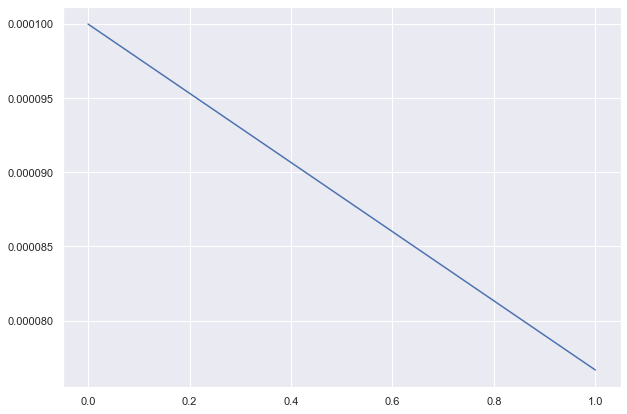

In [17]:
vis_lr_callback(BATCH_SIZES[0])

In [18]:
skf = KFold(n_splits=KFOLDS, shuffle=True, random_state=RANDOM_SEED)
oof_pred = []
oof_tar = []
oof_val = []
oof_f1 = []
oof_ids = []
oof_folds = []

train_files = np.array(train_files)



In [ ]:
for fold, (idxT, idxV) in enumerate(skf.split(train_files)):
    files_train = train_files[idxT]
    np.random.shuffle(files_train)
    files_valid = train_files[idxV]
    
    print(f"#"*25, f"""#### FOLD {fold + 1} #### Image Size: {IMG_SIZES[fold]} | model: {EFNS[EFF_NETS[fold]].__name__} | batch_size: {BATCH_SIZES[fold]*REPLICAS}""", "#"*25 );
    train_images = count_data_items(files_train)
    val_images = count_data_items(files_valid)
    print(f"#### Training: {train_images} | Validation {val_images}")
    
    # Build Model
    K.clear_session()
    with strategy.scope():
        model = build_model(IMG_SIZES[fold], ef=EFF_NETS[fold],
                            count=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS//4)
        print("#"*25)
        # SAVE BEST MODEL EACH FOLD
        sv = tf.keras.callbacks.ModelCheckpoint(
            f"fold-{fold}.h5", monitor="val_auc", verbose=0, save_best_only=True,
            save_weights_only=True, mode="max", save_freq="epoch"
        )
        
        # TRAIN
        print("Training.")
        history = model.fit(
            get_dataset(files_train, shuffle=True, repeat=True,
                        dim=IMG_SIZES[fold], batch_size=BATCH_SIZES[fold]),
                        epochs = EPOCHS[fold],
                        callbacks = [sv, get_lr_callback(BATCH_SIZES[fold])],
                        steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS//4,
                        validation_data=get_dataset(files_valid, shuffle=False, repeat=False, dim=IMG_SIZES[fold]),
                        verbose = 1
        )
        
        print("Loading best model")
        model.load_weights(f"fold-{fold}.h5")

        ds_valid = get_dataset(files_valid, labeled=False, return_image_ids=False,
                              repeat=True, shuffle=False, dim=IMG_SIZES[fold], batch_size=BATCH_SIZES[fold]*2)

        ct_valid = count_data_items(files_valid)
        STEPS = ct_valid/BATCH_SIZES[fold]/2/REPLICAS
        pred = model.predict(ds_valid, steps=STEPS, verbose=0)[:ct_valid,]
        oof_pred.append(np.mean(pred.reshape((ct_valid, 1), order="F"), axis = 1))


        # GET OOF TARGETS AND IDs
        ds_valid = get_dataset(files_valid, repeat=False, dim=IMG_SIZES[fold],
                              labeled=True, return_image_ids=True)
        oof_tar.append(np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]))
        
        if DISPLAY_PLOT:
            plt.figure(figsize=(8,6))
            sns.distplot(oof_pred[-1])
            plt.show()

            plt.figure(figsize=(15,5))
            plt.plot(np.arange(len(history.history["auc"])), history.history["auc"], "-o", label="Train AUC", color="#ff7f0e")
            plt.plot(np.arange(len(history.history["auc"])), history.history["val_auc"], "-o", label="Val AUC", color="#1f77b4")
            x = np.argmax(history.history["val_auc"])
            y = np.max(history.history["val_auc"])
            xdist = plt.xlim()[1] - plt.xlim()[0]
            ydist = plt.ylim()[1] - plt.ylim()[0]
            plt.scatter(x, y, s=200, color="#1f77b4")
            plt.text(x-0.03*xdist, y-0.13*ydist, f"max_auc{y}", size=14)
            plt.ylabel("auc", size=14)
            plt.xlabel("Epoch", size=14)
            plt.legend(loc=2)

            plt2 = plt.gca().twinx()
            plt2.plot(np.arange(len(history.history["auc"])), history.history["loss"], "-o", label="Train Loss", color = "#2ca02c")
            plt2.plot(np.arange(len(history.history["auc"])), history.history["val_loss"], "-o", label="Val Loss", color = "#d62728")
            x = np.argmin(history.history["val_loss"])
            y = np.min(history.history["val_loss"])
            ydist = plt.ylim()[1] - plt.ylim()[0]
            plt.scatter(x, y, s=200, color="#d62728")
            plt.text(x-0.03*xdist, y+0.05*ydist, "min loss")
            plt.ylabel("Loss", size=14)
            plt.title(f"FOLD {fold + 1} - Image Size {IMG_SIZES[fold]}, {EFNS[EFF_NETS[fold]].__name__}")
            plt.legent(loc=3)
            plt.savefig(f"fig{fold}.png")
            plt.show()


######################### #### FOLD 1 #### Image Size: 256 | model: EfficientNetB1 | batch_size: 2 #########################
#### Training: 350000 | Validation 140000
#########################
Training.
Epoch 1/2


In [ ]:
oof = np.concatenate(oof_pred)
true = np.concatenate(oof_tar)
auc = roc_auc_score(true, oof)
print(f"Overall OOF AUC = {auc}")